# Libraries

In [2]:
# Suppressing all warnings
import warnings
warnings.filterwarnings("ignore")

# Multiprocessing
import multiprocessing

# Threading
import threading

# Time
import time

# Data handling
import pandas as pd
import numpy as np

# Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Oversampling
from imblearn.over_sampling import ADASYN

# Metrics
from sklearn import metrics

# Preprocessing
from imblearn.over_sampling import ADASYN
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA

# Models
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.ensemble import AdaBoostClassifier
# from catboost import CatBoostClassifier

# Evaluation metrics

# Cross validation
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, train_test_split
from skopt import BayesSearchCV
from sklearn.metrics import classification_report

In [2]:
def multi_time():
    print("Starting thread...")
    start = time.time()

    while True:
        elapsed = int(time.time() - start)
        print(f"Time elapsed: {elapsed} seconds", end = "\r")
        time.sleep(1)

# Loading CSV file onto Pandas DataFrame

In [74]:
df = pd.read_csv("player_stats.csv", na_values="None")
df = df[["X", "Y", "xG", "h_a", "situation", "shotType", "lastAction", "result"]]
# df = df.loc[:50000, :].copy()

# Check for missing data and percentage

In [75]:
print("Percentage of data missing from each column\n")
for col in df.columns:
    if len(df[df[col].isnull() == True]):
        print(f"{col}: {len(df[df[col].isnull() == True])/len(df)*100}%", 
              end = "")
        print(f" or {len(df[df[col].isnull() == True])} rows")
    else:
        print(f"{col}: {0}%")

Percentage of data missing from each column

X: 0%
Y: 0%
xG: 0%
h_a: 0%
situation: 0%
shotType: 0%
lastAction: 9.228053426520521% or 10246 rows
result: 0%


# Dropping rows with missing values

In [76]:
df = df[df["lastAction"].isnull() == False].reset_index(drop =True).copy()
df = df.drop(df[df["result"]=="OwnGoal"].index)
df = df[df.situation != 'Penalty']

# Encoding categorical columns

* h_a: One-Hot Encoder
* situation: One-Hot Encoder
* shotType: One-Hot Encoder
* lastAction: One-Hot Encoder
* result: One-Hot Encoder

In [77]:
print(f"\x1b[32mUnique values in:\x1b[0m {df['h_a'].value_counts()}")
print(f"\x1b[32mUnique values in:\x1b[0m {df['situation'].value_counts()}")
print(f"\x1b[32mUnique values in:\x1b[0m {df['shotType'].value_counts()}")
print(f"\x1b[32mUnique values in:\x1b[0m {df['lastAction'].value_counts()}")
print(f"\x1b[32mUnique values in:\x1b[0m {df['result'].value_counts()}")

Unique values in: h    54108
a    44615
Name: h_a, dtype: int64
Unique values in: OpenPlay          82980
FromCorner         8514
SetPiece           3918
DirectFreekick     3311
Name: situation, dtype: int64
Unique values in: RightFoot        48933
LeftFoot         32717
Head             16725
OtherBodyPart      348
Name: shotType, dtype: int64
Unique values in: Pass               41618
Cross              15324
Aerial              7000
Chipped             6630
TakeOn              6616
Rebound             4705
Throughball         3515
Standard            3311
BallRecovery        3081
HeadPass            2644
BallTouch           1919
LayOff               707
Dispossessed         547
Tackle               221
CornerAwarded        194
BlockedPass          171
Foul                 159
Goal                  88
Interception          65
End                   64
OffsidePass           23
GoodSkill             23
Challenge             18
Card                  18
SubstitutionOn        16
Clearance 

In [78]:
remapping = {"Goal": 1, 
             "MissedShots": 0, 
             "SavedShot": 0, 
             "BlockedShot": 0, 
             "ShotOnPost": 0, 
             }

lastAction = {"Cross": ["Aerial", "Cross", "Chipped"] , 
              "Pass":["Pass", "Throughball", "HeadPass", "BallTouch", "TakeOn"],
              "Dispossessed":["Dispossessed", "Tackle", "BlockedPass", "Interception", 
                              "Challenge", "Clearance", "BallRecovery"],
              "Other":["Standard", "Rebound", "LayOff", "CornerAwarded", 
                       "Foul", "Goal", "End", "OffsidePass", 
              "GoodSkill", "Card", "SubstitutionOn", "OffsideProvoked",
                       "Save", "KeeperPickup", 
              "FormationChange", "Start", "ChanceMissed" , "ShieldBallOpp"]}

df["result"] = df["result"].map(remapping)
for k, v in lastAction.items():
    for i in v:
        df["lastAction"].replace(to_replace = i, value = k, inplace = True)

df_encoded = pd.get_dummies(df, 
                            drop_first = True)
df_encoded = df_encoded.loc[:50000, :]

In [79]:
X = df_encoded.drop(["result"], axis = 1).copy()
Y = df_encoded["result"].copy()

In [80]:
X_train, X_test, y_train, y_test_1 = train_test_split(X, Y,
                                                      train_size = 0.8,
                                                      stratify = Y)

# Step 2: Grid Search

In [81]:
pipe = Pipeline([("classifier", LogisticRegression())])

param_grid = [
    {
        'classifier': [LogisticRegression(random_state = 42)],
        'classifier__solver': ['saga', 'lbfgs'],
        'classifier__C': [0.1, 1],
    },
    {
        'classifier': [SVC(random_state = 42)],
        'classifier__C':[0.1, 1],
        'classifier__degree': [1, 2],
        'classifier__gamma': [0.1, 1],
    },
    {
        'classifier': [XGBClassifier(random_state = 42)],
        'classifier__n_estimators': [10, 1000],
        'classifier__max_depth': [10, 50],
    },
    {
        'classifier': [AdaBoostClassifier()],
        'classifier__base_estimator': [DecisionTreeClassifier(random_state = 42)],
        'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__base_estimator__criterion': ['gini', 'entropy'],
        'classifier__base_estimator__max_depth': [1, 5, 9],
    }
]

bs = GridSearchCV(pipe, param_grid, cv = 5, verbose = 3)
bs.fit(X_train, y_train)

Fitting 5 folds for each of 34 candidates, totalling 170 fits
[CV 1/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.879 total time=   0.1s
[CV 2/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.879 total time=   0.1s
[CV 3/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.876 total time=   0.1s
[CV 4/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.878 total time=   0.1s
[CV 5/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.876 total time=   0.1s
[CV 1/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=lbfgs;, score=0.879 total time=   0.2s
[CV 2/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=lbfgs;, score=0.

[CV 5/5] END classifier=SVC(random_state=42), classifier__C=1, classifier__degree=2, classifier__gamma=1;, score=0.876 total time=  42.4s
[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), classifier__max_depth=10, classifier__n_estimators=10;, score=0.881 total time=  

[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), classifier__max_depth=50, classifier__n_estimators=10;, score=0.873 total time=   1.0s
[CV 2/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.01;, score=0.867 total time=   1.7s
[CV 2/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.01;, score=0.867 total time=   1.6s
[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.01;, score=0.867 total time=   1.6s
[CV 4/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__

[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.01;, score=0.869 total time=   8.8s
[CV 4/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.01;, score=0.866 total time=   9.1s
[CV 5/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.01;, score=0.872 total time=   9.4s
[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__

[CV 5/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=0.01;, score=0.875 total time=   6.0s
[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=0.1;, score=0.876 total time=   6.1s
[CV 2/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=0.1;, score=0.876 total time=   5.9s
[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, cl

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('classifier', LogisticRegression())]),
             param_grid=[{'classifier': [LogisticRegression(random_state=42)],
                          'classifier__C': [0.1, 1],
                          'classifier__solver': ['saga', 'lbfgs']},
                         {'classifier': [SVC(random_state=42)],
                          'classifier__C': [0.1, 1],
                          'classifier__degree': [1, 2],
                          'classifier__gamma': [0.1, 1]},
                         {'classifier': [XGBClassi...
                         {'classifier': [AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                                                                  random_state=42),
                                                            learning_rate=1)],
                          'classifier__base_estimator': [DecisionTreeClassifier(max_depth=1,
                                                                                random_state=42)],
                          'classifier__base_estimator__criterion': ['gini',
                                                                    'entropy'],
                          'classifier__base_estimator__max_depth': [1, 5, 9],
                          'classifier__learning_rate': [0.01, 0.1, 1]}],
             verbose=3)

In [82]:
bs.best_params_

{'classifier': AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1,
                                                          random_state=42),
                    learning_rate=1),
 'classifier__base_estimator': DecisionTreeClassifier(max_depth=1, random_state=42),
 'classifier__base_estimator__criterion': 'gini',
 'classifier__base_estimator__max_depth': 1,
 'classifier__learning_rate': 1}

In [83]:
y_preds_1 = bs.predict(X_test)
acc = metrics.accuracy_score(y_test_1, y_preds_1)

In [84]:
cr_1 = classification_report(y_test_1, y_preds_1)
print(classification_report(y_test_1, y_preds_1))

              precision    recall  f1-score   support

           0       0.89      0.98      0.93      8502
           1       0.60      0.20      0.30      1307

    accuracy                           0.88      9809
   macro avg       0.74      0.59      0.62      9809
weighted avg       0.85      0.88      0.85      9809



# Recall isn't good for minority class

This can attributed to the heavy class imbalance in the dataset. We can try to balance this by first filtering data and then using ADASYN

## Higher cutoff for number of shots per player

In [85]:
def preprocessing(df, num_rows = 50000):

    print("\x1b[32mStarting preprocessing...\x1b[31m")
    
    df = df[["X", "Y", "xG", "h_a", "situation", "shotType", "lastAction", "result"]]
    df = df[df["lastAction"].isnull() == False].reset_index(drop =True).copy()
    df = df.drop(df[df["result"]=="OwnGoal"].index)
    df = df[df.situation != 'Penalty']
    remapping = {"Goal": 1, 
             "MissedShots": 0, 
             "SavedShot": 0, 
             "BlockedShot": 0, 
             "ShotOnPost": 0, 
             }

    lastAction = {"Cross": ["Aerial", "Cross", "Chipped"] , 
                  "Pass":["Pass", "Throughball", "HeadPass", "BallTouch", "TakeOn"],
                  "Dispossessed":["Dispossessed", "Tackle", "BlockedPass",
                                  "Interception", "Challenge", "Clearance",
                                  "BallRecovery"],
                  "Other":["Standard", "Rebound", "LayOff", "CornerAwarded",
                           "Foul", "Goal", "End", "OffsidePass", 
                  "GoodSkill", "Card", "SubstitutionOn", "OffsideProvoked",
                           "Save", "KeeperPickup", "FormationChange", 
                           "Start", "ChanceMissed" , "ShieldBallOpp"]}

    print("Remapping target column")
    df["result"] = df["result"].map(remapping)
    
    print("Remapping lastAction column")
    for k, v in lastAction.items():
        for i in v:
            df["lastAction"].replace(to_replace = i, value = k, inplace = True)

    print("One hot encoding remaining columns")
    df_encoded = pd.get_dummies(df, 
                                drop_first = True)
    if num_rows != None:
        print(f"Using only {num_rows} rows")
        df_encoded = df_encoded.loc[:num_rows, :]
    else:
        print(f"Using all rows")

    print("Preprocessing done\x1b[0m")
    return df_encoded

In [86]:
def search(X_train, y_train, verbosity = 1, use_svc = True):

    print("\x1b[32m Starting search...\x1b[31m")

    print("Building base pipeline")
    pipe = Pipeline([("classifier", LogisticRegression())])

    print("Building parameter grid")
    if use_svc:
        print("Using SVC")
        param_grid = [
    {
        'classifier': [LogisticRegression(random_state = 42)],
        'classifier__solver': ['saga', 'lbfgs'],
        'classifier__C': [0.1, 1],
    },
    {
        'classifier': [SVC(random_state = 42)],
        'classifier__C':[0.1, 1],
        'classifier__degree': [1, 2],
        'classifier__gamma': [0.1, 1],
    },
    {
        'classifier': [XGBClassifier(random_state = 42)],
        'classifier__n_estimators': [10, 1000],
        'classifier__max_depth': [10, 50],
    },
    {
        'classifier': [AdaBoostClassifier()],
        'classifier__base_estimator': [DecisionTreeClassifier(random_state = 42)],
        'classifier__learning_rate': [0.01, 0.1, 1],
        'classifier__base_estimator__criterion': ['gini', 'entropy'],
        'classifier__base_estimator__max_depth': [1, 5, 9],
    }
]
    else:
        print("Replacing SVC with KNN")
        param_grid = [
            {
                'classifier': [LogisticRegression(random_state = 42)],
                'classifier__solver': ['saga', 'lbfgs'],
                'classifier__C': [0.1, 1],
            },
            {
                'classifier': [KNeighborsClassifier()],
                'classifier__n_neighbors':[3, 4, 5],
                'classifier__p': [1, 2],
            },
            {
                'classifier': [XGBClassifier(random_state = 42)],
                'classifier__n_estimators': [10, 1000],
                'classifier__max_depth': [10, 50],
            },
            {
                'classifier': [AdaBoostClassifier()],
                'classifier__base_estimator': [DecisionTreeClassifier(random_state = 42)],
                'classifier__learning_rate': [0.01, 0.1, 1],
                'classifier__base_estimator__criterion': ['gini', 'entropy'],
                'classifier__base_estimator__max_depth': [1, 5, 9],
            }
        ]
    print("Creating Grid Search")
    bs = GridSearchCV(pipe, param_grid, cv = 5, verbose = verbosity)
    print("Fitting train data onto Grid Search")
    bs.fit(X_train, y_train)

    print(f"\x1b[32mBest Parameters:\x1b[0m\n {bs.best_params_}")        

    return bs

In [87]:
def test(best_model, X_test, y_test):
    y_pred = best_model.predict(X_test)
    acc = metrics.accuracy_score(y_test, y_pred)

    print(f"\x1b[32mClassification report on test accuracy:\x1b[0m\n {classification_report(y_test, y_pred)}")

    return y_pred, classification_report(y_test, y_pred)

In [88]:
df2 = pd.read_csv("player_stats.csv",  na_values="None")

df3 = df2.copy()

print("Before filtering, df shape", df3.shape)

df3_grouped = df3.groupby(["player", "result"]).size()
df3['shot_count'] = df3.groupby('player')['player'].transform('size')
df4 = df3.groupby(["player", 'shot_count', "result"])[['shot_count']].count()
df4 = df4.rename(columns = {'shot_count':'count'})
df5 = df4.sort_values(by = df4.index.names[1], ascending = False)
df5["result"] = df5.index.get_level_values(2)
df5.index = df5.index.droplevel(2)
df5['shot_count'] = df5.index.get_level_values(1)
df5.index= df5.index.droplevel(1)
df5 = df5[df5['shot_count']>40]
df3 = df3[df3["player"].isin(df5.index)]
print("After filtering, df shape", df3.shape)

df_encoded = preprocessing(df3, num_rows = None)
X = df_encoded.drop(["result"], axis = 1).copy()
Y = df_encoded["result"].copy()

X_train, X_test, y_train, y_test_2 = train_test_split(X, Y, 
                                                      train_size = 0.8,
                                                      stratify = Y)

best_model_2 = search(X_train, y_train, verbosity = 3,
                      use_svc = True)

y_preds_2, cr_2 = test(best_model_2, X_test, y_test_2)



Before filtering, df shape (111031, 20)
After filtering, df shape (108004, 21)
Starting preprocessing...
Remapping target column
Remapping lastAction column
One hot encoding remaining columns
Using all rows
Preprocessing done
 Starting search...
Building base pipeline
Building parameter grid
Using SVC
Creating Grid Search
Fitting train data onto Grid Search
Fitting 5 folds for each of 34 candidates, totalling 170 fits
[CV 1/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.882 total time=   0.3s
[CV 2/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.881 total time=   0.3s
[CV 3/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.879 total time=   0.3s
[CV 4/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.877 total time=   0.3s
[CV 5/5] END classifier=Logist

[CV 2/5] END classifier=SVC(random_state=42), classifier__C=1, classifier__degree=2, classifier__gamma=1;, score=0.877 total time= 2.7min
[CV 3/5] END classifier=SVC(random_state=42), classifier__C=1, classifier__degree=2, classifier__gamma=1;, score=0.877 total time= 2.7min
[CV 4/5] END classifier=SVC(random_state=42), classifier__C=1, classifier__degree=2, classifier__gamma=1;, score=0.876 total time= 2.6min
[CV 5/5] END classifier=SVC(random_state=42), classifier__C=1, classifier__degree=2, classifier__gamma=1;, score=0.878 total time= 2.8min
[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
  

[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), classifier__max_depth=10, classifier__n_estimators=1000;, score=0.872 total time=   6.1s
[CV 1/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsamp

[CV 5/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), classifier__max_depth=50, classifier__n_estimators=1000;, score=0.869 total time=  23.5s
[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base

[CV 4/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=5, classifier__learning_rate=1;, score=0.874 total time=  10.3s
[CV 5/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=5, classifier__learning_rate=1;, score=0.878 total time=  10.4s
[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.01;, score=0.878 total time=  17.8s
[CV 2/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learni

[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=0.01;, score=0.883 total time=  11.8s
[CV 2/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=0.01;, score=0.879 total time=  11.7s
[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=0.01;, score=0.881 total time=  11.8s
[CV 4/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, 

Classification report on test accuracy:
               precision    recall  f1-score   support

           0       0.89      0.98      0.93     16711
           1       0.60      0.22      0.32      2498

    accuracy                           0.88     19209
   macro avg       0.75      0.60      0.63     19209
weighted avg       0.86      0.88      0.85     19209



# Metrics didn't increase as much.

Let's try oversampling using ADASYN and replace KNN with SVC

In [29]:
df2 = pd.read_csv("player_stats.csv",  na_values="None")

df3 = df2.copy()

print("Before filtering, df shape", df3.shape)

df3_grouped = df3.groupby(["player", "result"]).size()
df3['shot_count'] = df3.groupby('player')['player'].transform('size')
df4 = df3.groupby(["player", 'shot_count', "result"])[['shot_count']].count()
df4 = df4.rename(columns = {'shot_count':'count'})
df5 = df4.sort_values(by = df4.index.names[1], ascending = False)
df5["result"] = df5.index.get_level_values(2)
df5.index = df5.index.droplevel(2)
df5['shot_count'] = df5.index.get_level_values(1)
df5.index= df5.index.droplevel(1)
df5 = df5[df5['shot_count']>40]
df3 = df3[df3["player"].isin(df5.index)]
print("After filtering, df shape", df3.shape)

df_encoded = preprocessing(df3, num_rows = 50000)
df5_g = df_encoded[df_encoded["result"]==1]
df5_ng = df_encoded[df_encoded["result"]==0]

print("\x1b[32mBefore ADASYN\x1b[0m")
print(f"Ratio of goals to not goals: {len(df5_g)/len(df5_ng)}")

print("\x1b[31mOversampling using ADASYN\x1b[0m")
X = df_encoded.drop(["result"], axis = 1).copy()
Y = df_encoded["result"].copy()

X_resampled, y_resampled = ADASYN().fit_resample(X, Y)
print("\x1b[32mAfter ADASYN\x1b[0m")
print(f"Number of samples added by ADASYN {len(y_resampled) - len(Y)}, or {(len(y_resampled) - len(Y))/len(y_resampled)}% increase")
print(f"Ratio of goals to not goals: {len(y_resampled[y_resampled == 1])/len(y_resampled[y_resampled == 0])}")

X_train, X_test, y_train, y_test_3 = train_test_split(X_resampled, y_resampled,
                                                      train_size = 0.8, 
                                                      stratify = y_resampled)

best_model_3 = search(X_train, y_train, verbosity = 3, use_svc = False)

y_preds_3, cr_3 = test(best_model_3, X_test, y_test_3)

Before filtering, df shape (111031, 20)
After filtering, df shape (108004, 21)
Starting preprocessing...
Remapping target column
Remapping lastAction column
One hot encoding remaining columns
Using only 50000 rows
Preprocessing done
Before ADASYN
Ratio of goals to not goals: 0.15363253394836554
Oversampling using ADASYN
After ADASYN
Number of samples added by ADASYN 35941, or 0.4230343691148776% increase
Ratio of goals to not goals: 0.9994822432985809
 Starting search...
Building base pipeline
Building parameter grid
Replacing SVC with KNN
Creating Grid Search
Fitting train data onto Grid Search
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.692 total time=   0.3s
[CV 2/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.689 total time=   0.3s
[CV 3/5] END classifier=LogisticRegression(random_state=42), 

[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), classifier__max_depth=10, classifier__n_estimators=10;, score=0.723 total time=   0.1s
[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), classifier__max_depth=50, classifier__n_estimators=10;, score=0.808 total time=   3.6s
[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.1;, score=0.694 total time=   3.7s
[CV 2/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.1;, score=0.690 total time=   3.8s
[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.1;, score=0.692 total time=   3.5s
[CV 4/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__lea

[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.1;, score=0.894 total time=  19.7s
[CV 4/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.1;, score=0.901 total time=  20.1s
[CV 5/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.1;, score=0.898 total time=  19.4s
[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__lea

[CV 5/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=0.1;, score=0.768 total time=  14.5s
[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=1;, score=0.817 total time=  14.5s
[CV 2/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=1;, score=0.817 total time=  14.1s
[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classif

# Entire dataset since it can run faster

In [93]:
df2 = pd.read_csv("player_stats.csv",  na_values="None")

df3 = df2.copy()

print("Before filtering, df shape", df3.shape)

df3_grouped = df3.groupby(["player", "result"]).size()
df3['shot_count'] = df3.groupby('player')['player'].transform('size')
df4 = df3.groupby(["player", 'shot_count', "result"])[['shot_count']].count()
df4 = df4.rename(columns = {'shot_count':'count'})
df5 = df4.sort_values(by = df4.index.names[1], ascending = False)
df5["result"] = df5.index.get_level_values(2)
df5.index = df5.index.droplevel(2)
df5['shot_count'] = df5.index.get_level_values(1)
df5.index= df5.index.droplevel(1)
df5 = df5[df5['shot_count']>40]
df3 = df3[df3["player"].isin(df5.index)]
print("After filtering, df shape", df3.shape)

df_encoded = preprocessing(df3, num_rows = None)
df5_g = df_encoded[df_encoded["result"]==1]
df5_ng = df_encoded[df_encoded["result"]==0]

print("\x1b[32mBefore ADASYN\x1b[0m")
print(f"Ratio of goals to not goals: {len(df5_g)/len(df5_ng)}")

print("\x1b[31mOversampling using ADASYN\x1b[0m")
X = df_encoded.drop(["result"], axis = 1).copy()
Y = df_encoded["result"].copy()

X_resampled, y_resampled = ADASYN().fit_resample(X, Y)
print("\x1b[32mAfter ADASYN\x1b[0m")
print(f"Number of samples added by ADASYN {len(y_resampled) - len(Y)}, or {(len(y_resampled) - len(Y))/len(y_resampled)*100}% increase")
print(f"Ratio of goals to not goals: {len(y_resampled[y_resampled == 1])/len(y_resampled[y_resampled == 0])}")

X_train, X_test, y_train, y_test_4 = train_test_split(X_resampled, y_resampled,
                                                      train_size = 0.8,
                                                      stratify = y_resampled)

best_model_4 = search(X_train, y_train, verbosity = 3, use_svc = False)

y_preds_4, cr_4 = test(best_model_4, X_test, y_test_4)

Before filtering, df shape (111031, 20)
After filtering, df shape (108004, 21)
Starting preprocessing...
Remapping target column
Remapping lastAction column
One hot encoding remaining columns
Using all rows
Preprocessing done
Before ADASYN
Ratio of goals to not goals: 0.14946022931277975
Oversampling using ADASYN
After ADASYN
Number of samples added by ADASYN 72397, or 42.981138572420875% increase
Ratio of goals to not goals: 1.0159298178423535
 Starting search...
Building base pipeline
Building parameter grid
Replacing SVC with KNN
Creating Grid Search
Fitting train data onto Grid Search
Fitting 5 folds for each of 32 candidates, totalling 160 fits
[CV 1/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.673 total time=   0.8s
[CV 2/5] END classifier=LogisticRegression(random_state=42), classifier__C=0.1, classifier__solver=saga;, score=0.677 total time=   0.8s
[CV 3/5] END classifier=LogisticRegression(random_state=42), classif

[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), classifier__max_depth=10, classifier__n_estimators=10;, score=0.716 total time=   0.2s
[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

[CV 3/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...), classifier__max_depth=50, classifier__n_estimators=10;, score=0.812 total time=   9.0s
[CV 4/5] END classifier=XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample

[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.1;, score=0.681 total time=   7.3s
[CV 2/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.1;, score=0.682 total time=   7.0s
[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__learning_rate=0.1;, score=0.683 total time=   6.7s
[CV 4/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=1, classifier__lea

[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.1;, score=0.908 total time=  40.3s
[CV 4/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.1;, score=0.909 total time=  39.7s
[CV 5/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__learning_rate=0.1;, score=0.907 total time=  38.8s
[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=gini, classifier__base_estimator__max_depth=9, classifier__lea

[CV 5/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=0.1;, score=0.841 total time=  27.7s
[CV 1/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=1;, score=0.825 total time=  27.9s
[CV 2/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classifier__learning_rate=1;, score=0.824 total time=  28.3s
[CV 3/5] END classifier=AdaBoostClassifier(), classifier__base_estimator=DecisionTreeClassifier(random_state=42), classifier__base_estimator__criterion=entropy, classifier__base_estimator__max_depth=5, classif

# Classification Reports

In [96]:
print("\x1b[32mBaseline evaluation metrics:\x1b[0m")
print("\x1b[31mNumber of rows = 50000")
print("List of models:\nLogistic Regression\nSVC\nXgboost\nAdaBoost\x1b[0m")
print(cr_1)

print("\x1b[36mMinority class recall and precision was low.\x1b[0m")
print("\x1b[36mChoosing top 75% percentile of players with respect to number of shots\x1b[0m")

print("\x1b[32mEvaluation metrics after choosing cutoff of number of shots for each player(top 75% percentile):\x1b[0m")
print("\x1b[31mNumber of rows = 50000")
print("List of models:\nLogistic Regression\nSVC\nXgboost\nAdaBoost\x1b[0m")
print(cr_2)

print("\x1b[36mMetrics did not change by much\x1b[0m")

print("\x1b[36mOversampling using ADASYN to balance classes and replacing SVC with KNN\x1b[0m")
print("\x1b[32mEvaluation metrics after oversampling and replacing SVC with KNN:\x1b[0m")
print("\x1b[31mNumber of rows = 50000")
print("List of models:\nLogistic Regression\nKNN\nXgboost\nAdaBoost\x1b[0m")
print(cr_3)

print("\x1b[36mMetrics increased by a significant amount with respect to minority class and grid search ran computationally much faster.\x1b[0m")
print("\x1b[36mRunning gridsearch again with entire dataset\x1b[0m")
print("\x1b[31mNumber of rows = entire dataset")
print("List of models:\nLogistic Regression\nKNN\nXgboost\nAdaBoost\x1b[0m")
print(cr_4)

Baseline evaluation metrics:
Number of rows = 50000
List of models:
Logistic Regression
SVC
Xgboost
AdaBoost
              precision    recall  f1-score   support

           0       0.89      0.98      0.93      8502
           1       0.60      0.20      0.30      1307

    accuracy                           0.88      9809
   macro avg       0.74      0.59      0.62      9809
weighted avg       0.85      0.88      0.85      9809

Minority class recall and precision was low.
Choosing top 75% percentile of players with respect to number of shots
Evaluation metrics after choosing cutoff of number of shots for each player(top 75% percentile):
Number of rows = 50000
List of models:
Logistic Regression
SVC
Xgboost
AdaBoost
              precision    recall  f1-score   support

           0       0.89      0.98      0.93     16711
           1       0.60      0.22      0.32      2498

    accuracy                           0.88     19209
   macro avg       0.75      0.60      0.63     19209

# Confusion Matrices

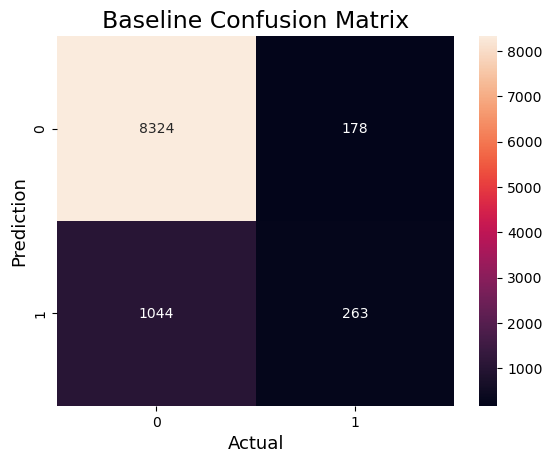

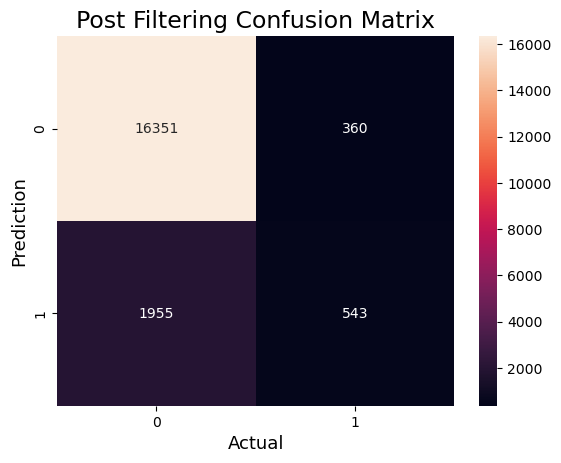

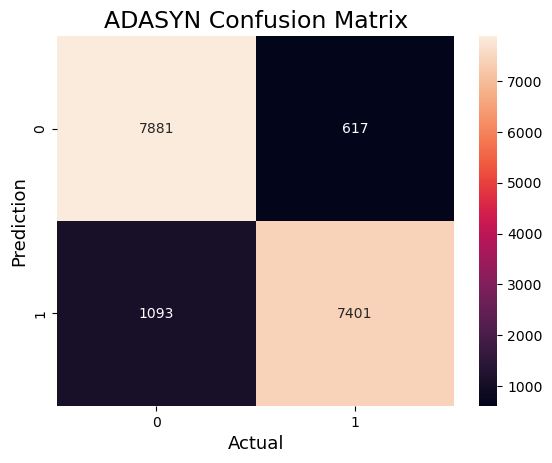

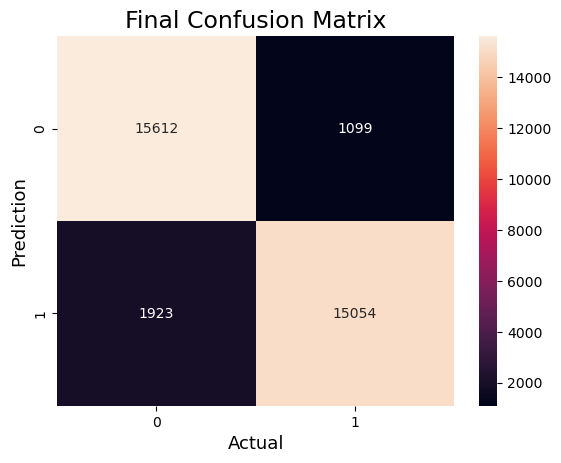

In [97]:
cm_1 = metrics.confusion_matrix(y_test_1, y_preds_1)
cm_2 = metrics.confusion_matrix(y_test_2, y_preds_2)
cm_3 = metrics.confusion_matrix(y_test_3, y_preds_3)
cm_4 = metrics.confusion_matrix(y_test_4, y_preds_4)

sns.heatmap(cm_1, 
            annot=True,
            fmt='g', 
            xticklabels=range(2),
            yticklabels=range(2))
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Baseline Confusion Matrix',fontsize=17)
plt.show()

sns.heatmap(cm_2, 
            annot=True,
            fmt='g', 
            xticklabels=range(2),
            yticklabels=range(2))
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Post Filtering Confusion Matrix',fontsize=17)
plt.show()

sns.heatmap(cm_3, 
            annot=True,
            fmt='g', 
            xticklabels=range(2),
            yticklabels=range(2))
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('ADASYN Confusion Matrix',fontsize=17)
plt.show()

sns.heatmap(cm_4, 
            annot=True,
            fmt='g', 
            xticklabels=range(2),
            yticklabels=range(2))
plt.ylabel('Prediction',fontsize=13)
plt.xlabel('Actual',fontsize=13)
plt.title('Final Confusion Matrix',fontsize=17)
plt.show()

# AUC_ROC Curves

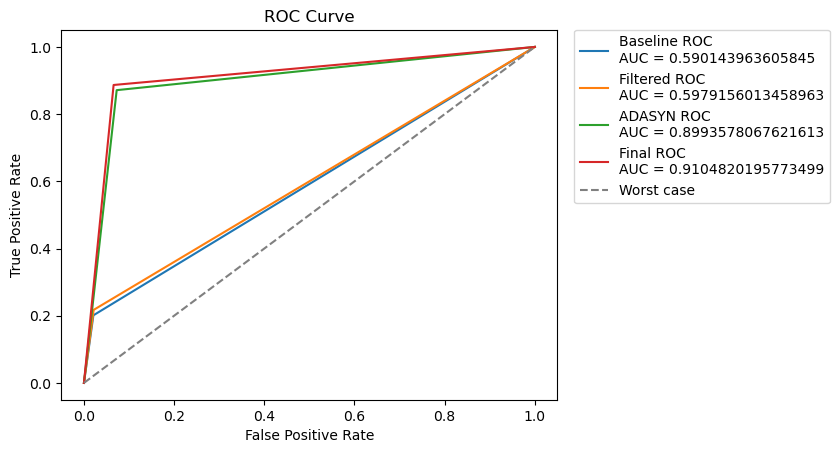

In [98]:
fpr_1, tpr_1, _ = metrics.roc_curve(y_test_1, y_preds_1)
auc_1 = metrics.roc_auc_score(y_test_1, y_preds_1)

plt.plot(fpr_1, tpr_1, label='Baseline ROC\nAUC = '+ str(auc_1))
# plt.plot([0, 1], [0, 1], '--', color='grey', label='Worst case')
plt.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# plt.legend();

fpr_2, tpr_2, _ = metrics.roc_curve(y_test_2, y_preds_2)
auc_2 = metrics.roc_auc_score(y_test_2, y_preds_2)

plt.plot(fpr_2, tpr_2, label='Filtered ROC\nAUC = '+ str(auc_2))
# plt.plot([0, 1], [0, 1], '--', color='grey', label='Worst case')
plt.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# plt.legend();

fpr_3, tpr_3, _ = metrics.roc_curve(y_test_3, y_preds_3)
auc_3 = metrics.roc_auc_score(y_test_3, y_preds_3)

plt.plot(fpr_3, tpr_3, label='ADASYN ROC\nAUC = '+ str(auc_3))
# plt.plot([0, 1], [0, 1], '--', color='grey', label='Worst case')
plt.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
# plt.legend();

fpr_4, tpr_4, _ = metrics.roc_curve(y_test_4, y_preds_4)
auc_4 = metrics.roc_auc_score(y_test_4, y_preds_4)

plt.plot(fpr_4, tpr_4, label='Final ROC\nAUC = '+ str(auc_4))
plt.plot([0, 1], [0, 1], '--', color='grey', label='Worst case')
plt.plot()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(bbox_to_anchor = (1.02, 1.02));

# Heatmap

## Predicted Label Heatmap

<Figure size 30720x23040 with 0 Axes>

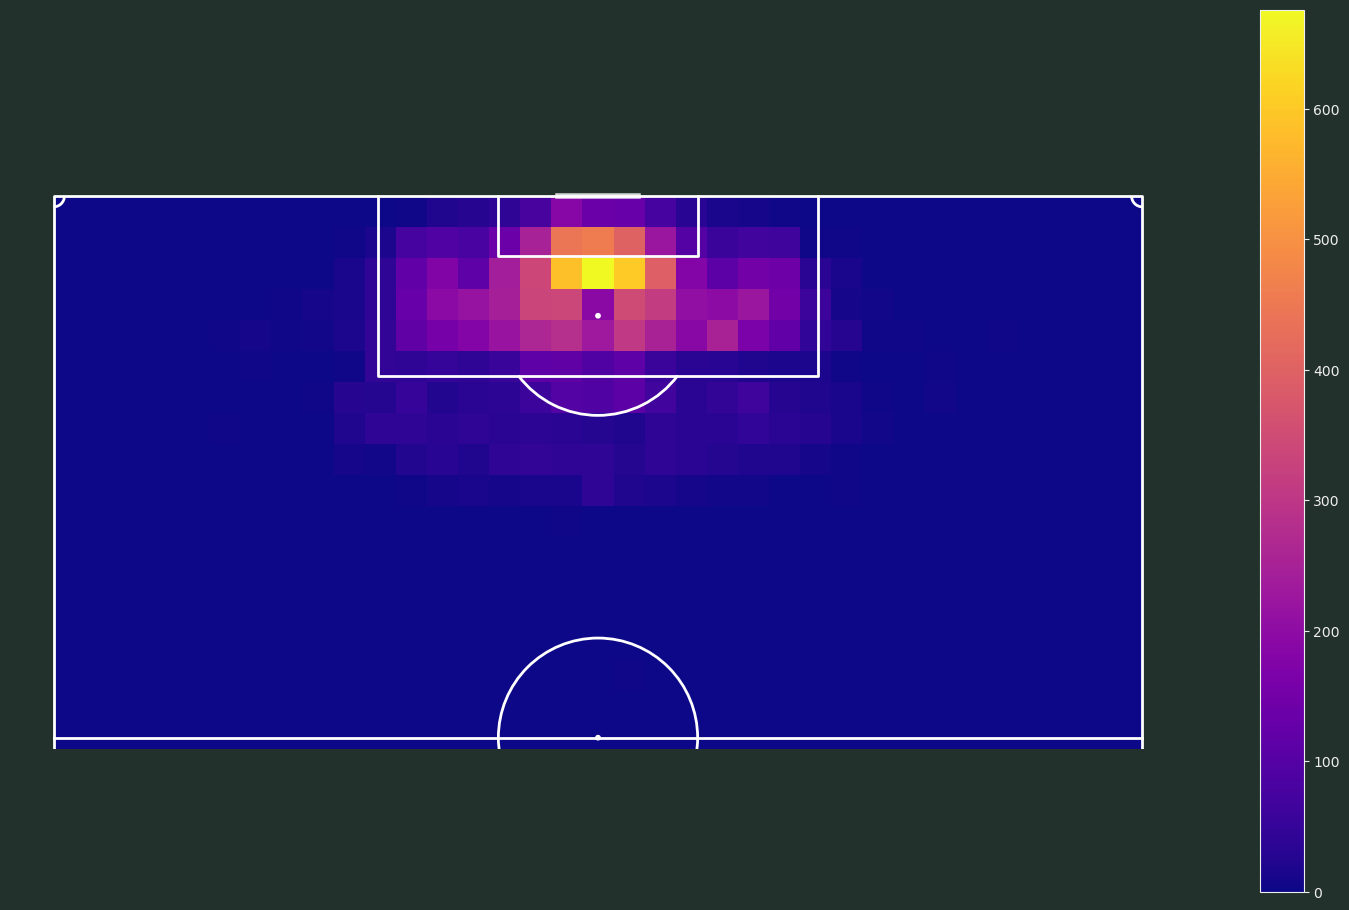

In [94]:
# from highlight_text import fig_text
import matplotlib.patheffects as path_effects

from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from sklearn.model_selection import train_test_split

mean_with_zero = lambda x: np.sum(x) if not np.sum(np.sum(x)) else 0
pred_heatmap = pd.concat([pd.DataFrame(X_test), pd.Series(y_preds_4,index=X_test.index)], axis = 1)

pred_heatmap = pred_heatmap.rename(columns = {0 : 'Result'})

plt.figure(dpi=4800) 
path_eff = [path_effects.Stroke(linewidth=0.5, foreground='black'),
            path_effects.Normal()]
pitch = VerticalPitch(pad_bottom = 1, half = True, goal_type = 'line', goal_alpha = 0.8,
                      pitch_type = 'custom', pitch_length = 99.5, pitch_width = 100,
                     line_zorder=2, line_color='white', corner_arcs=True, pitch_color='#22312b')

fig, ax = pitch.draw(figsize=(15,15))
fig.set_facecolor('#22312b')

bin_statistic = pitch.bin_statistic(pred_heatmap.X * 100, pred_heatmap.Y* 100, 
                                    values = pred_heatmap.Result, statistic='sum', bins=(35, 35))

bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], -10)

pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='plasma')
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)

cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')

ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
# labels = pitch.label_heatmap(bin_statistic, color='black', fontsize=10,
#                              ax=ax, ha='center', va='center',
#                              str_format='{:.2f}%', path_effects=path_eff)

## True Label Heatmap

<Figure size 30720x23040 with 0 Axes>

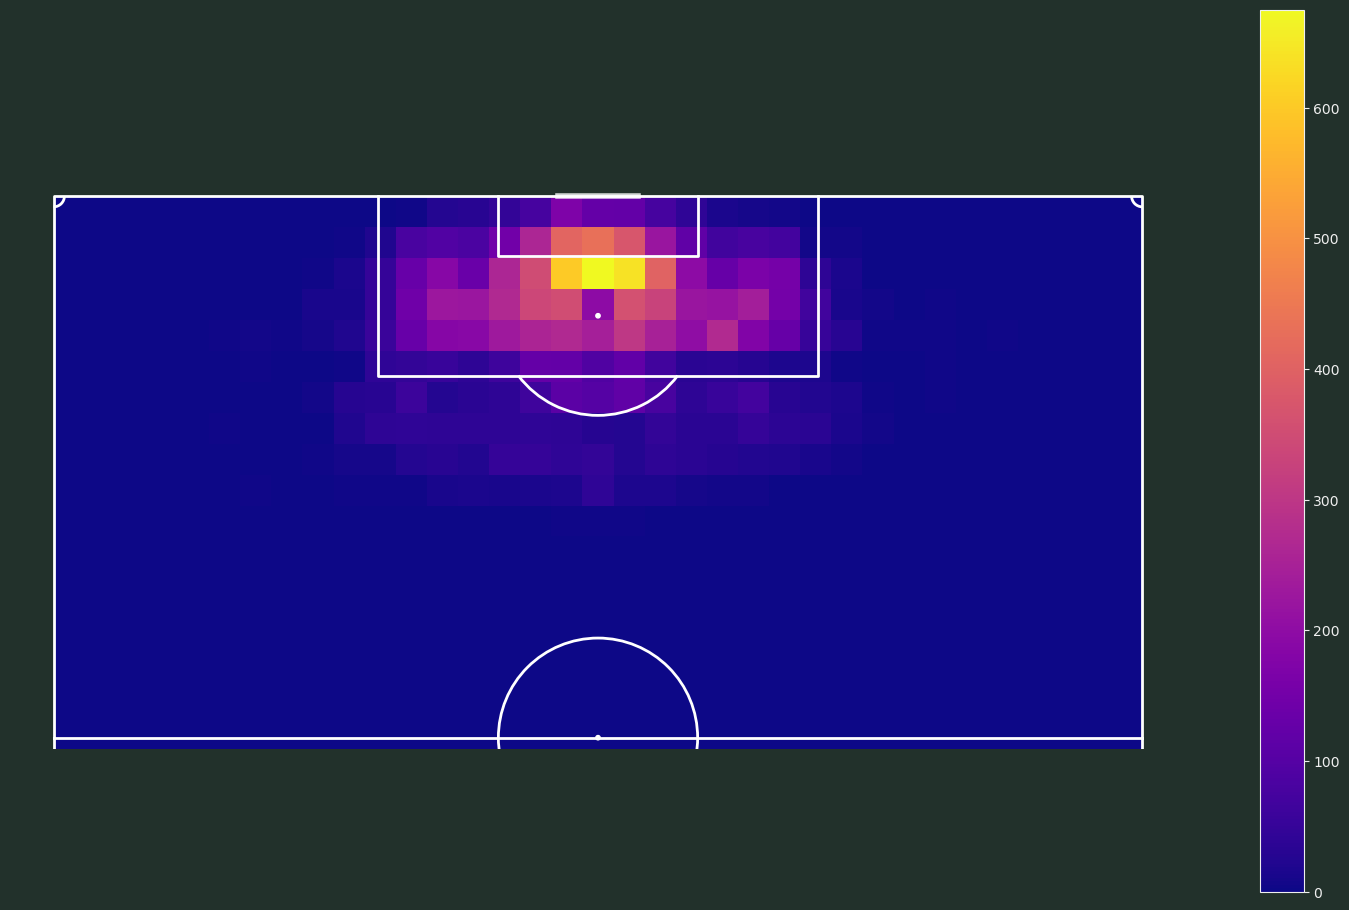

In [95]:
# from highlight_text import fig_text
import matplotlib.patheffects as path_effects

from matplotlib.colors import LinearSegmentedColormap
from scipy.ndimage import gaussian_filter

from mplsoccer import Pitch, VerticalPitch, FontManager, Sbopen
from sklearn.model_selection import train_test_split

mean_with_zero = lambda x: np.sum(x) if not np.sum(np.sum(x)) else 0
pred_heatmap = pd.concat([pd.DataFrame(X_test), pd.Series(y_test_4,index=X_test.index)], axis = 1)

# pred_heatmap = pred_heatmap.rename(columns = {0 : 'Result'})

plt.figure(dpi=4800) 
path_eff = [path_effects.Stroke(linewidth=0.5, foreground='black'),
            path_effects.Normal()]
pitch = VerticalPitch(pad_bottom = 1, half = True, goal_type = 'line', goal_alpha = 0.8,
                      pitch_type = 'custom', pitch_length = 99.5, pitch_width = 100,
                     line_zorder=2, line_color='white', corner_arcs=True, pitch_color='#22312b')

fig, ax = pitch.draw(figsize=(15,15))
fig.set_facecolor('#22312b')

bin_statistic = pitch.bin_statistic(pred_heatmap.X * 100, pred_heatmap.Y* 100, 
                                    values = pred_heatmap.result, statistic='sum', bins=(35, 35))

bin_statistic['statistic'] = gaussian_filter(bin_statistic['statistic'], -10)

pcm = pitch.heatmap(bin_statistic, ax=ax, cmap='plasma')
cbar = fig.colorbar(pcm, ax=ax, shrink=0.6)

cbar.outline.set_edgecolor('#efefef')
cbar.ax.yaxis.set_tick_params(color='#efefef')

ticks = plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='#efefef')
# labels = pitch.label_heatmap(bin_statistic, color='black', fontsize=10,
#                              ax=ax, ha='center', va='center',
#                              str_format='{:.2f}%', path_effects=path_eff)